In [6]:
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
import argparse

In [7]:
def read_dimacs_cnf(filename):
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith("c"):
                continue
            if line.startswith("p cnf"):
                num_vars, num_clauses = map(int, line.strip().split()[2:])
            else:
                clause = list(map(int, line.strip().split()[:-1]))
                clauses.append(clause)
    return num_vars, clauses

In [8]:
def visualize_hypergraph(clauses):
    G = nx.DiGraph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))  
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))  

    pos = nx.spring_layout(G, scale=10) 
    nx.draw_networkx(G, pos, with_labels=True, node_size=500, arrowsize=20)
    plt.show()

def generate_node_embeddings(clauses):
    G = nx.DiGraph()
    for clause in clauses:
        for literal in clause:
            G.add_node(abs(literal))
        for i in range(len(clause)):
            for j in range(i+1, len(clause)):
                G.add_edge(abs(clause[i]), abs(clause[j]))

    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)
    return model, G

def create_directed_graph(G, model):
    G_directed = nx.DiGraph()
    for i in sorted(G.nodes):
        node, weight = model.wv.most_similar(f'{i}')[0]
        G_directed.add_edge(i, int(node), weight=round(weight, 2))

    pos = nx.spring_layout(G_directed, scale=10)
    nx.draw(G_directed, pos, with_labels=True, node_size=150, arrowsize=20, edge_color='red', font_color='black', font_weight='bold')
    labels = nx.get_edge_attributes(G_directed, 'weight')
    nx.draw_networkx_edge_labels(G_directed, pos, edge_labels=labels)
    plt.title("Directed Graph Visualization")
    plt.show()

def visualize_hypergraph_coloring(G, model):
    pos = nx.spring_layout(G, scale=10)
    node_colors = [model.wv.get_vector(str(node))[0] for node in G.nodes]
    edge_colors = [model.wv.get_vector(str(edge[0]))[0] for edge in G.edges]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Blues, node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrowsize=20)
    
    plt.show()

In [9]:
def main(filename):
    num_vars, clauses = read_dimacs_cnf(filename)
    model, G = generate_node_embeddings(clauses)

    visualize_hypergraph(clauses)
    visualize_hypergraph_coloring(G, model)

Computing transition probabilities: 100%|██████████| 100/100 [00:00<00:00, 11816.94it/s]

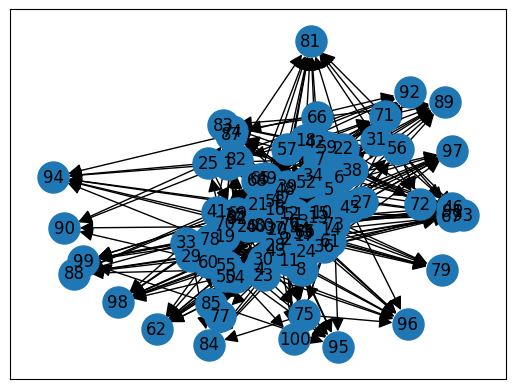

C:\Users\karol\AppData\Local\Temp\ipykernel_3904\4130197905.py:46: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrowsize=20)


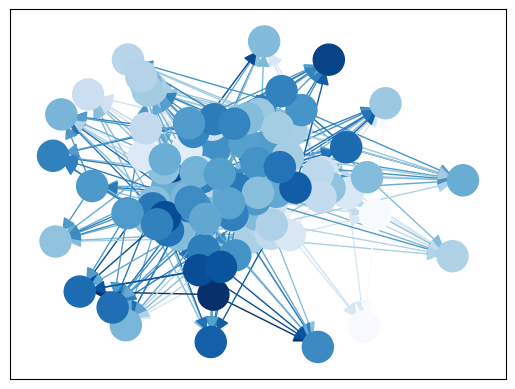

In [10]:
filename = "DIMACS_files/turbo_easy/example_2.cnf"
main(filename)